In [1]:
#import libraries
import gym 
import numpy as np 
import math 
import tensorflow as tf
from matplotlib import pyplot as plt
from random import randint
from statistics import median, mean 


In [2]:
env = gym.make('CartPole-v0')
no_states = env.observation_space.shape[0]
no_actions = env.action_space.n

In [3]:
#function to generate initial network parameters
def initial(run_test):
    #initialize arrays
    i_w = []
    i_b = []
    h_w = []
    o_w = []
    no_input_nodes = 8
    no_hidden_nodes = 4
    
    for r in range(run_test):
        input_weight = np.random.rand(no_states, no_input_nodes)
        input_bias = np.random.rand((no_input_nodes))
        hidden_weight = np.random.rand(no_input_nodes,no_hidden_nodes)
        output_weight = np.random.rand(no_hidden_nodes, no_actions)
        
        i_w.append(input_weight)
        i_b.append(input_bias)
        h_w.append(hidden_weight)
        o_w.append(output_weight)
        
    chromosome =[i_w, i_b, h_w, o_w]
    return chromosome        

In [4]:
#function for deep neural network model
def nnmodel(observations, i_w, i_b, h_w, o_w):
    alpha = 0.199
    observations = observations/max(np.max(np.linalg.norm(observations)),1)
    #apply relu on layers
    funct1 = np.dot(observations, i_w)+ i_b.T
    layer1= tf.nn.relu(funct1)-alpha*tf.nn.relu(-funct1)
    funct2 = np.dot(layer1,h_w)
    layer2 = tf.nn.relu(funct2) - alpha*tf.nn.relu(-funct2)
    funct3 = np.dot(layer2, o_w)
    layer3 = tf.nn.relu(funct3)-alpha*tf.nn.relu(-funct3)
    #apply softmax
    layer3 = np.exp(layer3)/np.sum(np.exp(layer3))
    output = layer3.argsort().reshape(1,no_actions)
    action = output[0][0]
    
    return action
    

In [5]:
#function for getting the reward
def get_reward(env, i_w, i_b, h_w, o_w):
    current_state = env.reset()
    total_reward = 0
    for step in range(300):
        action = nnmodel(current_state, i_w, i_b, h_w, o_w)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        current_state = next_state
        if done:
            break
    return total_reward

In [6]:
#function for an initial run to get weights
def get_weights(env, run_test):
    rewards = []
    chromosomes = initial(run_test)
    for trial in range(run_test):
        i_w = chromosomes[0][trial]
        i_b = chromosomes[1][trial]
        h_w = chromosomes[2][trial]
        o_w = chromosomes[3][trial]
        total_reward = get_reward(env, i_w, i_b, h_w, o_w)
        rewards = np.append(rewards, total_reward)
    chromosome_weight = [chromosomes, rewards]
    return chromosome_weight

In [7]:
#function for mutation:
def mutate(parent):
    index = np.random.randint(0, len(parent))
    if(0 < index < 10):
        for idx in range(index):
            n = np.random.randint(0, len(parent))
            parent[n] = parent[n] + np.random.rand()
    mutation = parent
    return mutation

In [8]:
#function for cross-over
def crossover(list_chr):
    gen_list = []
    gen_list.append(list_chr[0])
    gen_list.append(list_chr[1])
    
    for i in range(10):
        m = np.random.randint(0, len(list_chr[0]))
        parent = np.append(list_chr[0][:m], list_chr[1][m:])
        child = mutate(parent)
        gen_list.append(child)
    return gen_list

In [9]:
#function for a new generation of parameters
def generate_new_population(rewards, chromosomes):
    #2 best reward indexes selected
    best_reward_idx = rewards.argsort()[-2:][::-1]
    list_chr = []
    new_i_w =[]
    new_i_b = []
    new_h_w = []
    new_o_w = []
    new_rewards = []
    
    #get current parameters
    for ind in best_reward_idx:
        weight1 = chromosomes[0][ind]
        w1 = weight1.reshape(weight1.shape[1], -1)
        
        bias1 = chromosomes[1][ind]
        b1 = np.append(w1, bias1)
        
        weight2 = chromosomes[2][ind]
        w2 = np.append(b1, weight2.reshape(weight2.shape[1], -1))
        
        weight3 = chromosomes[3][ind]
        chr = np.append(w2, weight3)
        #the 2 best parents are selected
        list_chr.append(chr)
        
    gen_list = crossover(list_chr)
    
    for l in gen_list:
        chromosome_w1 = np.array(l[:chromosomes[0][0].size])
        new_input_weight = np.reshape(chromosome_w1,(-1,chromosomes[0][0].shape[1]))
        new_input_bias = np.array([l[chromosome_w1.size:chromosome_w1.size+chromosomes[1][0].size]]).T
        hidden = chromosome_w1.size + new_input_bias.size
        chromosome_w2 = np.array([l[hidden:hidden + chromosomes[2][0].size]])
        new_hidden_weight = np.reshape(chromosome_w2, (-1, chromosomes[2][0].shape[1]))
        final = chromosome_w1.size+new_input_bias.size+chromosome_w2.size
        new_output_weight = np.array([l[final:]]).T
        new_output_weight = np.reshape(new_output_weight,(-1, chromosomes[3][0].shape[1]))
        
        new_i_w.append(new_input_weight)
        new_i_b.append(new_input_bias)
        new_h_w.append(new_hidden_weight)
        new_o_w.append(new_output_weight)
        
        new_reward = get_reward(env, new_input_weight, new_input_bias, new_hidden_weight, new_output_weight)
        new_rewards = np.append(new_rewards, new_reward)
        
    generation = [new_i_w, new_i_b, new_h_w, new_o_w]
    
    return generation, new_rewards
        
    

In [10]:
#function to print graphics
def graphics(act):
    plt.plot(act)
    plt.xlabel('No. of generations')
    plt.ylabel('Rewards')
    plt.grid()
    
    print('Mean rewards:', mean(act))
    return plt.show()
    

In [11]:
#run genetic alhorithm
def ga_algo(env, run_test, no_gen):
    weights = get_weights(env, run_test)
    
    chrom = weights[0]
    current_rewards = weights[1]
    act = []
    
    for n in range(no_gen):
        gen, new_rewards = generate_new_population(current_rewards, chrom)
        average = np.average(current_rewards)
        new_average = np.average(new_rewards)
        if average >  new_average:
            parameters = [chrom[0][0], chrom[1][0], chrom[2][0], chrom[3][0]]
        else:
             parameters = [gen[0][0], gen[1][0], gen[2][0], gen[3][0]]
        chrom = gen
        current_rewards = new_rewards
        max_arg = np.amax(current_rewards)
        print('Generation:{}, max reward:{}'.format(n+1, max_arg))
        act = np.append(act, max_arg)

    
    graphics(act)
    
    return parameters
    
    

In [12]:
#function for outputting the initial parameters
def params(parameters):
    i_w = parameters[0]
    i_b = parameters[1]
    h_w = parameters[2]
    o_w = parameters[3]
    
    return i_w,i_b,h_w,o_w

Generation:1, max reward:11.0
Generation:2, max reward:11.0
Generation:3, max reward:10.0
Generation:4, max reward:10.0
Generation:5, max reward:11.0
Generation:6, max reward:10.0
Generation:7, max reward:10.0
Generation:8, max reward:10.0
Generation:9, max reward:11.0
Generation:10, max reward:10.0
Generation:11, max reward:10.0
Generation:12, max reward:10.0
Generation:13, max reward:10.0
Generation:14, max reward:10.0
Generation:15, max reward:10.0
Generation:16, max reward:10.0
Generation:17, max reward:10.0
Generation:18, max reward:10.0
Generation:19, max reward:11.0
Generation:20, max reward:11.0
Generation:21, max reward:10.0
Generation:22, max reward:11.0
Generation:23, max reward:10.0
Generation:24, max reward:11.0
Generation:25, max reward:10.0
Generation:26, max reward:10.0
Generation:27, max reward:10.0
Generation:28, max reward:10.0
Generation:29, max reward:10.0
Generation:30, max reward:10.0
Generation:31, max reward:11.0
Generation:32, max reward:11.0
Generation:33, ma

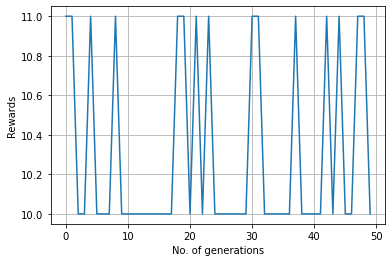

Trial:0, total reward:11.0
Trial:1, total reward:9.0
Trial:2, total reward:10.0
Trial:3, total reward:10.0
Trial:4, total reward:10.0
Trial:5, total reward:9.0
Trial:6, total reward:10.0
Trial:7, total reward:9.0
Trial:8, total reward:11.0
Trial:9, total reward:10.0
Trial:10, total reward:10.0
Trial:11, total reward:8.0
Trial:12, total reward:9.0
Trial:13, total reward:9.0
Trial:14, total reward:10.0
Trial:15, total reward:8.0
Trial:16, total reward:9.0
Trial:17, total reward:9.0
Trial:18, total reward:9.0
Trial:19, total reward:11.0
Trial:20, total reward:9.0
Trial:21, total reward:10.0
Trial:22, total reward:9.0
Trial:23, total reward:9.0
Trial:24, total reward:10.0
Trial:25, total reward:11.0
Trial:26, total reward:10.0
Trial:27, total reward:9.0
Trial:28, total reward:10.0
Trial:29, total reward:10.0
Trial:30, total reward:8.0
Trial:31, total reward:10.0
Trial:32, total reward:10.0
Trial:33, total reward:9.0
Trial:34, total reward:10.0
Trial:35, total reward:9.0
Trial:36, total rew

Trial:293, total reward:9.0
Trial:294, total reward:9.0
Trial:295, total reward:9.0
Trial:296, total reward:10.0
Trial:297, total reward:8.0
Trial:298, total reward:9.0
Trial:299, total reward:9.0
Trial:300, total reward:8.0
Trial:301, total reward:10.0
Trial:302, total reward:9.0
Trial:303, total reward:10.0
Trial:304, total reward:9.0
Trial:305, total reward:9.0
Trial:306, total reward:9.0
Trial:307, total reward:9.0
Trial:308, total reward:9.0
Trial:309, total reward:10.0
Trial:310, total reward:10.0
Trial:311, total reward:9.0
Trial:312, total reward:9.0
Trial:313, total reward:10.0
Trial:314, total reward:9.0
Trial:315, total reward:9.0
Trial:316, total reward:9.0
Trial:317, total reward:10.0
Trial:318, total reward:9.0
Trial:319, total reward:8.0
Trial:320, total reward:8.0
Trial:321, total reward:10.0
Trial:322, total reward:9.0
Trial:323, total reward:9.0
Trial:324, total reward:10.0
Trial:325, total reward:9.0
Trial:326, total reward:8.0
Trial:327, total reward:10.0
Trial:328,

In [13]:
generations = []
no_gen = 50
run_test = 15
trial_length = 500
no_trials = 500
rewards = []
final_reward = 0

parameters = ga_algo(env, run_test, no_gen)
i_w, i_b, h_w, o_w = params(parameters)



for trial in range(no_trials):
    current_state = env.reset()
    total_reward = 0
    for step in range(trial_length):
        env.render()
        action = nnmodel(current_state, i_w,i_b, h_w, o_w)
        next_state,reward, done, info = env.step(action)
        total_reward += reward
        current_state = next_state
        if done:
            break
    print('Trial:{}, total reward:{}'.format(trial, total_reward))
    final_reward +=total_reward
print('Average reward:', final_reward/no_trials)
env.close()
